In [1]:
# %load_ext tensorboard

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer

from genotype.genotype import RandomArchitectureGenerator

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [2]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]




In [3]:
# helper functions

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, classes):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    fig.tight_layout()
    return fig

In [4]:
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
testset = datasets.MNIST('mnist_test', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# Setup
Setup the RAG model and send info to tensorboard

Final depth:4
Number of nodes:10


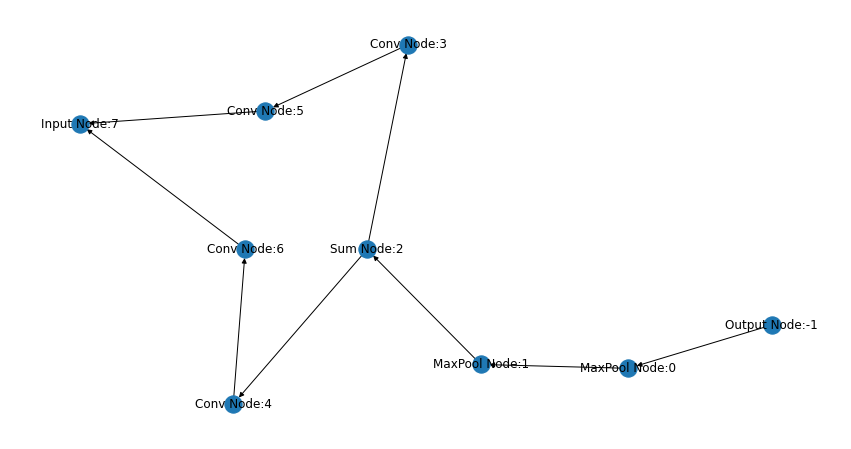

In [5]:
writer = SummaryWriter()

images, labels = next(iter(trainloader))

rag = RandomArchitectureGenerator(
    prediction_classes=10,
    min_depth=5,
    max_depth=7,
    image_size=int(images.shape[2]),
    input_channels=int(images.shape[1]),
    min_nodes=5
)

rag.get_architecture()
cont = rag.controller()
rag.show()

In [6]:
list(cont.named_parameters())

[('module_dict.8:Conv_Node.model.0.weight',
  Parameter containing:
  tensor([[[[-0.0026, -0.2131, -0.2398],
            [ 0.0441,  0.3042,  0.0367],
            [ 0.0206,  0.0086,  0.2252]]],
  
  
          [[[-0.1537, -0.1985,  0.0838],
            [ 0.3100, -0.1721,  0.2800],
            [ 0.0998, -0.1382, -0.2527]]],
  
  
          [[[ 0.2623,  0.3249, -0.3041],
            [ 0.3008, -0.1164,  0.2419],
            [ 0.2958, -0.1352,  0.1218]]],
  
  
          ...,
  
  
          [[[ 0.0917, -0.2317, -0.1724],
            [ 0.2914,  0.1144, -0.0217],
            [ 0.1703, -0.2199,  0.0719]]],
  
  
          [[[ 0.1616, -0.2350, -0.2404],
            [-0.0568,  0.1986,  0.2501],
            [-0.2588,  0.0929, -0.1801]]],
  
  
          [[[ 0.0052, -0.2581, -0.1848],
            [-0.1305, -0.0196,  0.1477],
            [ 0.0822,  0.3036,  0.3173]]]], requires_grad=True)),
 ('module_dict.8:Conv_Node.model.0.bias',
  Parameter containing:
  tensor([ 0.2500, -0.0671,  0.1731, -0.08

In [6]:
grid = torchvision.utils.make_grid(images)

# writer.add_image('images', grid, 0)
# writer.add_graph(my_nn, images)
cont(images)

running_loss = 0.0

cont.to(device)
optimizer = optim.Adam(cont.parameters(), lr=0.001,)   
criterion = nn.CrossEntropyLoss()

# can add milestones in later if needed
# milestones = [k for k in range(0, num_epochs*len(trainloader), 50)]

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.95)

G:\OneDrive - UNSW\University\Postgraduate\Year 3 Trimester 2\COMP9417\Major Project\src\genotype\models.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  v = F.softmax(v)


In [7]:
batch_tt = np.empty(shape=(10,))
k=0
num_epochs = 2
start_t = default_timer()
for epoch in range(num_epochs-1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        batch_st = default_timer() 
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = [d.to(device) for d in data]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cont(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         scheduler.step()

        running_loss += loss.item()
        
        batch_et = default_timer()
        
        batch_tt[k] = batch_et - batch_st
        
        k+=1
        
        if i % 10 == 9:    # every 10 batches...
            
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(trainloader) + i)
            writer.add_scalar('Learning rate',+
                            optimizer.param_groups[0]['lr'],
                            epoch * len(trainloader) + i)
            writer.add_scalar('Average batch time',
                            np.mean(batch_tt).item(),
                            epoch * len(trainloader) + i)
            
            running_loss = 0.0
            batch_tt = np.empty(shape=(10,))
            k=0
        


end_t = default_timer()

total_t = end_t - start_t

writer.add_scalar('Total training time',
                   total_t,
                epoch * len(trainloader) + i)

        

RuntimeError: All input tensors must be on the same device. Received cuda:1 and cpu

In [18]:
outputs.shape

torch.Size([16, 1, 28, 28])

In [18]:
inputs.shape

torch.Size([16, 1, 28, 28])